In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import os
PROJ_ROOT = os.path.join(os.pardir)

df_path = os.path.join(PROJ_ROOT, 
                         'data',
                          'topics_data.csv')

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
full_data = pd.read_csv(df_path)
full_data['created_at'] = pd.to_datetime(full_data['created_at'])

In [4]:
def vader_sent_df(df=full_data):
    '''Returns a new df with VADER sentiment scores'''
    
    s_vader=SentimentIntensityAnalyzer() #instantiate Analyzer
    
    #create a list of scores for each tweet
    sent_scores = [s_vader.polarity_scores(sent) for sent in df.full_text]
    
    #Add each emotion (positive, negative & compound) scores to the dataframe
    for emotion in sent_scores[0].keys():
        df[emotion+'_sentiment'] = [x[emotion] for x in sent_scores]
    
#     df.index.rename('created_at',inplace=True)
#     df=df.reset_index() #reset the index
    
    return df

def plot_vader_sent(df, title='all'):
    '''Plot the sentiment scores '''
    date_ranges=pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat
    # create a list of each emotion
    vals = df.pos_sentiment.tolist()
    n_vals = [x*-1 for x in df.neg_sentiment.tolist()]
    c_vals = df.compound_sentiment.tolist()
    

    #plot the moving averages
    xmin = max(date_ranges)
    xmax = min(date_ranges)
    plt.figure(figsize=(15, 10)) 
    plt.plot(date_ranges,vals, color='blue', alpha=.3, label='positive')
    plt.plot(n_vals,color='red', alpha=.3, label='negative')
    plt.plot(c_vals,color='green', label='compound')
#     plt.hlines(.05, xmin, xmax, linestyles = 'dotted', label='positive')
#     plt.hlines(-.05,xmin,xmax,linestyles = 'dotted', label='negative')
    plt.axhspan(-.05,.05,xmin,xmax, color='grey', alpha=.2,label='neutral')

    
    # label the plot and show
    plt.xlabel('Tweets')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Score Across Time for {} data'.format(title))
    plt.grid(which='major',axis='x')
    plt.legend()
    plt.show()
    plt.savefig('sent_over_time.png', bbox_inches='tight')


In [5]:
#add sentiment analysis to the dataframe
tweet_sent=vader_sent_df()

In [6]:
tweet_sent['created_at'] = pd.to_datetime(tweet_sent['created_at'])

In [7]:
from collections import defaultdict



def aggregate_by_day(df):
        date_ranges=pd.date_range(start=df.created_at.min(), end=df.created_at.max(), freq='D')
        date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat
        tweets_by_day=defaultdict(list)
        df=df.set_index('created_at')
        for day in date_ranges:
            tweets_by_day[day].append(df.loc[day].full_text.tolist())
        
        return tweets_by_day


In [8]:
#aggreagate all the tweet text by day
tweets_by_day=aggregate_by_day(full_data)
for day,tweets in tweets_by_day.items():
    tweets_by_day[day]=[text for tweet in tweets for text in tweet]
    tweets_by_day[day]= ''.join(tweets_by_day[day][0])
    
tweets_by_day = pd.DataFrame.from_dict(tweets_by_day, orient='index', columns=['full_text'])

In [9]:
tweets_by_day.head()

,full_text
02-22-2021,If there’s one message I want to cut through t...
02-23-2021,Here’s what's in the COVID relief package:\n \...
02-24-2021,Will the National Endowment for the Arts be he...
02-25-2021,"Six weeks ago, 14% of people over 75 in the US..."
02-26-2021,Tell me why I’ve received multiple emails and ...


In [10]:
#add sentiment analysis to the dataframe
tweet_sent_day=vader_sent_df(df=tweets_by_day)
tweet_sent_day.index=tweets_by_day.index

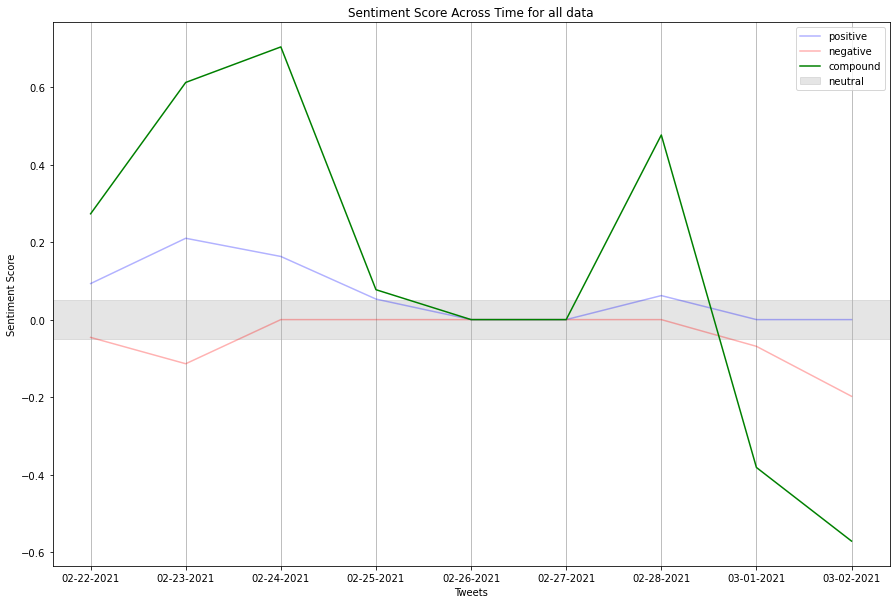

<Figure size 432x288 with 0 Axes>

In [11]:
plot_vader_sent(tweet_sent_day)

In [12]:
def df_plot_by_topic(df):

    for title in df.topic_title.unique():
        print(title)
        tmp=df[df.topic_title==title]

        #aggreagate all the tweet text by day
        tweets_by_day=aggregate_by_day(tmp)
        
        for day,tweets in tweets_by_day.items():
            tweets_by_day[day]=[text for tweet in tweets for text in tweet]
            tweets_by_day[day]= ''.join(tweets_by_day[day][0])


        tweets_by_day = pd.DataFrame.from_dict(tweets_by_day, orient='index', columns=['full_text'])
        

        #add sentiment analysis to the dataframe
        tweet_sent_day=vader_sent_df(df=tweets_by_day)

        plot_vader_sent(tweet_sent_day,title)



Covid News Updates


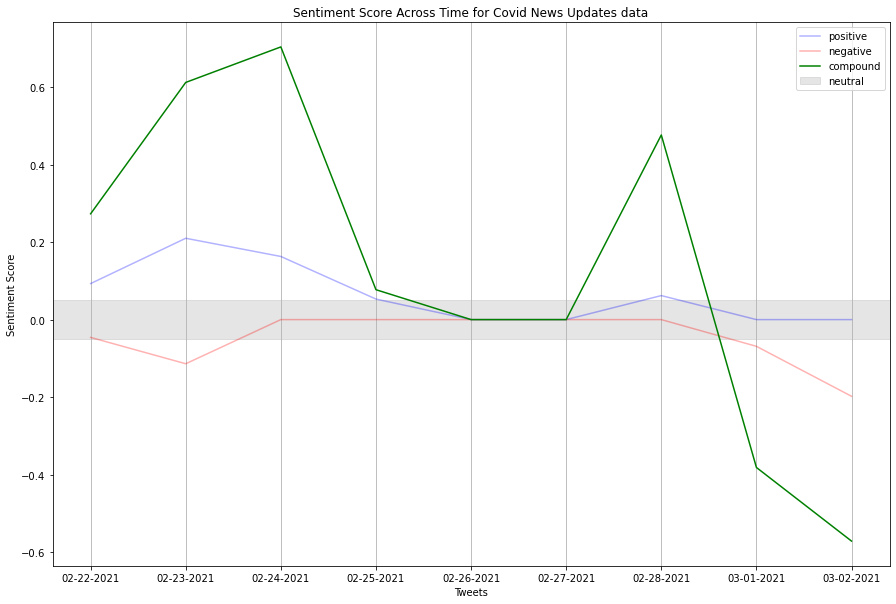

Vaccine Information


<Figure size 432x288 with 0 Axes>

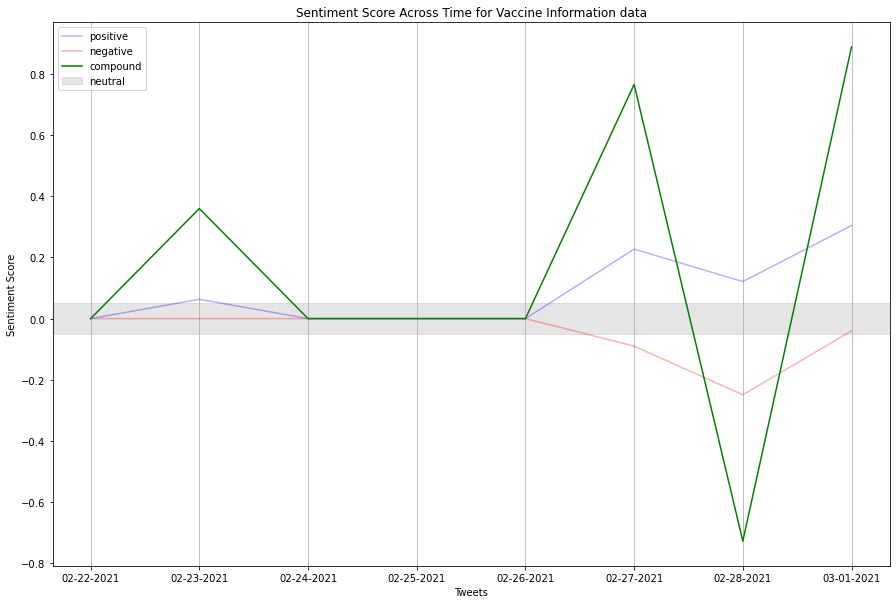

Vaccine/Communities


<Figure size 432x288 with 0 Axes>

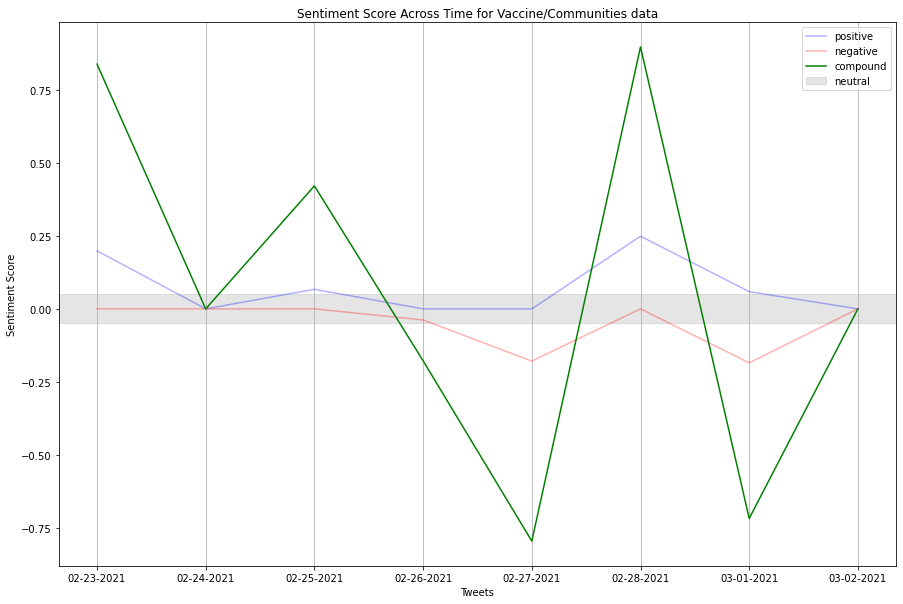

Opinion


<Figure size 432x288 with 0 Axes>

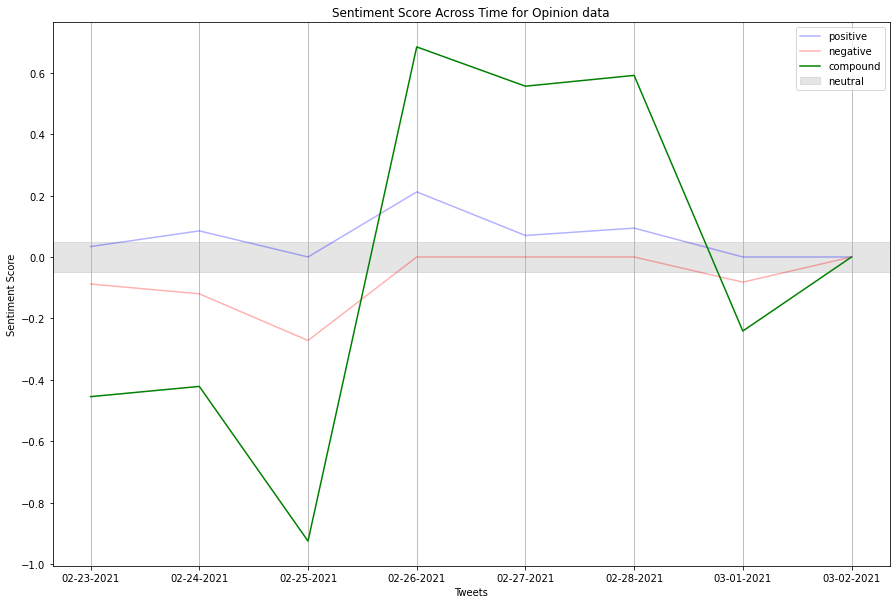

<Figure size 432x288 with 0 Axes>

In [15]:
df_plot_by_topic(full_data)

In [16]:
full_data.columns

Index(['created_at', 'tweet_id', 'full_text', 'geo', 'coordinates', 'place',
       'retweet_count', 'favorite_count', 'possibly_sensitive', 'lang',
       'user_id', 'user_location', 'user_verified', 'user_followers_count',
       'tokens', 'topic', 'rating', 'topic_title', 'covid_news_updates',
       'vaccine_information', 'vaccine_communities', 'opinion',
       'dominant_topic', 'topic_perc_contrib', 'keywords', 'neg_sentiment',
       'neu_sentiment', 'pos_sentiment', 'compound_sentiment'],
      dtype='object')

<AxesSubplot:xlabel='user_followers_count', ylabel='compound_sentiment'>

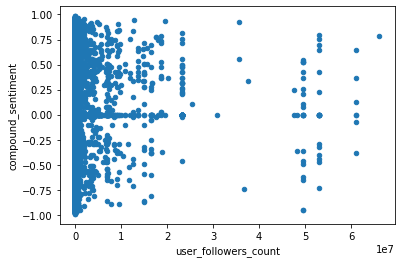

In [17]:
full_data[['compound_sentiment','user_followers_count']].plot.scatter('user_followers_count','compound_sentiment')

### Who were the most positive and negative twitter users with the most followers?

In [18]:
top_pos = full_data[['compound_sentiment','user_followers_count','user_id','full_text']]
top_pos = top_pos[(top_pos.user_followers_count>5000000) & (top_pos.compound_sentiment>.05)]
print('Top 5 positive tweets by those with the most followers')
[print(str(i+1)+'\n'+tweet+'\n-----\n') for i,tweet in enumerate(top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].full_text.tolist()) ]
print('scores \n',top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].compound_sentiment.tolist())
print('no of followers \n',top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].user_followers_count.tolist())

print('Twitter Ids')
top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].user_id.tolist()

Top 5 positive tweets by those with the most followers
1
India handled Covid better than many other countries.
India will now  handle vaccination better than many other countries.

All the best to all Indians as we enter the next phase of vaccination!

Stay healthy. Stay compassionate. When it's your turn, get your vaccine!
-----

2
बस हो गया! 

The first dosage of COVID-19 vaccine was administered to me at RR Hospital today.

India’s resolve for making the country COVID free has been strengthened by this inoculation drive. The Vaccine is completely safe and hassle free. 
#LargestVaccineDrive https://t.co/sKsrtLeGqi
-----

3
Hope everyone is alright! Had my wisdom teeth out recently, ruthless stuff! I'll be on in a few days. Sending you all love
-----

4
About 2.5 million women have been forced out of the workforce during the pandemic. The American Rescue Plan provides relief to women and families with $1,400 payments, a $3,000 child tax credit, and funding to safely reopen schools and

[44588485.0, 1346439824.0, 84279963.0, 8.036941790794588e+17, 355989081.0]

Those 5 Twitter users:<br>
ID Conversions from https://tweeterid.com/:<br><br>
44588485 => @chetan_bhagat<br>
Chetan Bhagat is an Indian author and columnist. He was included in Time magazine's list of World's 100 Most Influential People in 2010. <br><br>
1346439824 => @rajnathsingh<br>
Rajnath Singh is an Indian politician serving as the Defence Minister of India. He is the former President of Bharatiya Janata Party.<br><br>
84279963 => @Louis_Tomlinson<br>
Louis William Tomlinson is an English singer and songwriter. He rose to fame as a member of the boy band One Direction. <br><br>
803694179079458816 => @VP
The vice president of the United States <br><br> 
355989081 => @ANI<br>
Asian News International is an Indian news agency that offers syndicated multimedia news feed to multiple news-bureaus in India and beyond. 

In [19]:
top_neg = full_data[['compound_sentiment','user_followers_count','user_id','full_text']]
top_neg = top_neg[(top_neg.user_followers_count>4000000) & (top_neg.compound_sentiment<-.05)]
print('Top 5 positive tweets by those with the most followers')
[print(str(i+1)+'\n'+tweet+'\n-----\n') for i,tweet in enumerate(top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].full_text.tolist()) ]
print('scores \n',top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].compound_sentiment.tolist())
print('no of followers \n',top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].user_followers_count.tolist())

print('Twitter Ids')
top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].user_id.tolist()

Top 5 positive tweets by those with the most followers
1
Attacks against Asian-Americans in New York City have soared since the pandemic began, terrifying many and stoking fears of targeted violence. The xenophobia is also compounded by the economic fallout of the pandemic and fears of the coronavirus.
https://t.co/X0p9Rg5mZt https://t.co/dy1Aej1JAc
-----

2
Attacks against Asian-Americans in New York City have soared since the pandemic began, terrifying many and stoking fears of targeted violence. The xenophobia is also compounded by the economic fallout of the pandemic and fears of the coronavirus.
https://t.co/9sbMfgQWzv
-----

3
How annoying that the Brazil variant snuck into Britain during the many weeks we knew about it but didn’t shut our border. 
Damn that virus for not respecting our Govt’s right to dither and delay.
-----

4
One year ago today, Kayleigh McEnany made a really bad COVID prediction, but what's really special is how she also made a bad terrorism prediction in the

[807095.0, 807095.0, 216299334.0, 158414847.0, 51241574.0, 7587032.0]

Those 5 Twitter users:<br><br>
807095 => @nytimes<br>
51241574 => @AP<br>
216299334 => @piersmorgan<br>
Piers Stefan Pughe-Morgan is an English broadcaster, journalist, writer, and television personality. <br>
158414847 => @TheDailyShow<br>
51241574 => @AP<br><br>

This does not track well for negative sentiments.<br>
- Most are news outlets<br>
- Results may be different if subjectiviiy is taken into account, some of these are covid updates on deaths, illness etc. Which are counted as a negative sentiment.<br>
- Sentiment can be re-run with these keywords removed to get a better sense of the sentiment<br>

In [21]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [22]:
# functions to determine sentiment based on intensity/subjectivity scores for TextBlob

def sent_scores(row):
  subj = row['tb_score']
  if row['compound_sent'] < .05 and row['compound_sent'] > -.05:
    return 'neu'
  elif row['neg_sent'] < .2 and row['pos_sent'] - row['neg_sent'] > 0:
        return 'pos'
  elif row['pos_sent'] < .2 and row['neg_sent'] - row['pos_sent'] > 0:
        return 'neg'
  else:
    return 'neu'

def sent_subj(row):
  subj = row['tb_score']
  if row['compound_sent'] < .05 and row['compound_sent'] > -.05:
    return 'neu'
  elif row['pos_sent'] - row['neg_sent'] > .05 and row['tb_subj']>.30 and row['neg_sent']>0 and row['compound_sent']>.5:
        return 'pos'
  elif row['neg_sent'] - row['pos_sent'] > .05 and row['tb_subj']>.30 and row['pos_sent']>0 and row['compound_sent']<-.5:
        return 'neg'
  else:
    return 'neu'

In [23]:
s_vader = SentimentIntensityAnalyzer() # instantiate the Analyzer

#process the VADER score for all sentences in the df
vader_score = [s_vader.polarity_scores(sent) for sent in tqdm(full_data.full_text)] 

#add each sentiment option as a column in the dataframe, and place the score for each for each sentence
for scores in vader_score[0].keys():
    full_data[scores+'_sent'] = [x[scores] for x in vader_score ]

<ipython-input-23-01cc73d9691e>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  vader_score = [s_vader.polarity_scores(sent) for sent in tqdm(full_data.full_text)]


  0%|          | 0/51157 [00:00<?, ?it/s]

textblob sentiment

In [24]:
#obtain the sentiment polarity & subjectivity scores for each tweet
tb_score = [TextBlob(sent).polarity for sent in tqdm(full_data.full_text)]
tb_sub_score = [TextBlob(sent).subjectivity for sent in tqdm(full_data.full_text)]

#place the polarity and subjectivity scores into the dataframe
full_data['tb_score']=tb_score
full_data['tb_subj']=tb_sub_score

<ipython-input-24-1b48cb5fcb02>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tb_score = [TextBlob(sent).polarity for sent in tqdm(full_data.full_text)]


  0%|          | 0/51157 [00:00<?, ?it/s]

<ipython-input-24-1b48cb5fcb02>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tb_sub_score = [TextBlob(sent).subjectivity for sent in tqdm(full_data.full_text)]


  0%|          | 0/51157 [00:00<?, ?it/s]

In [25]:
# add the TextBlob sentiment with the rules in the defined functions
full_data['tb_sent'] = full_data.apply(sent_scores, axis=1)
full_data['tb_sent_subj'] = full_data.apply(sent_subj, axis=1)
# add the VADER sentiment to the dataframe
full_data['v_sent'] = full_data.apply(lambda x: 'pos' if x['compound_sent']>=.05 else ('neg' if x['compound_sent']<=-.05 else 'neu'), axis=1)

In [26]:
sent_bytopic_dict = defaultdict(list)

sent_vals = {'neu','pos','neg'}

for x, topic in enumerate(full_data.topic_title.unique()):
    cnts = full_data[full_data.topic_title==topic].tb_sent_subj.value_counts(normalize=True)
    
    for idx in cnts.index:
        sent_bytopic_dict[idx+'_p'].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_bytopic_dict[s+'_p'].append(0)
    
    
    cnts = full_data[full_data.topic_title==topic].tb_sent_subj.value_counts()
    
    for idx in cnts.index:
        sent_bytopic_dict[idx].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_bytopic_dict[s].append(0)
    
    sent_bytopic_dict['topic'].append(topic)

In [27]:
sent_cnts_topic = pd.DataFrame.from_dict(sent_bytopic_dict)
display(sent_cnts_topic.head(2))

,neu_p,pos_p,neg_p,neu,pos,neg,topic
0,0.911735,0.045925,0.042339,9152,461,425,Covid News Updates
1,0.899161,0.047648,0.053191,11681,619,691,Vaccine Information


Text(-85.075, 0.5, 'Topic')

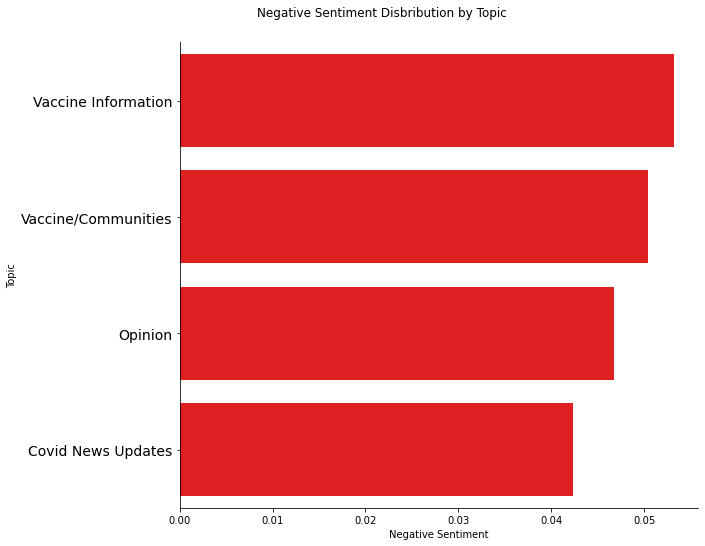

In [28]:
plot=sns.catplot(y='topic',
                 x='neg_p', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neg_p'],ascending=False), 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Disbribution by Topic', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-85.075, 0.5, 'Topic')

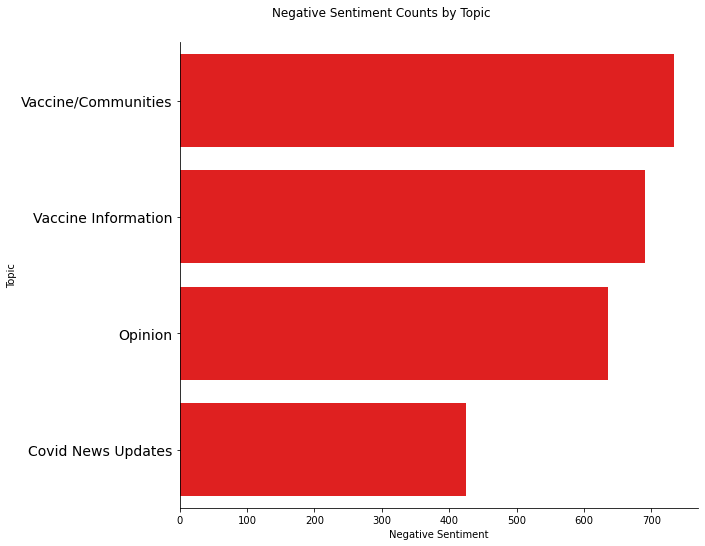

In [29]:
plot=sns.catplot(y='topic',
                 x='neg', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neg'],ascending=False), 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Topic')

Text(-85.075, 0.5, 'Topic')

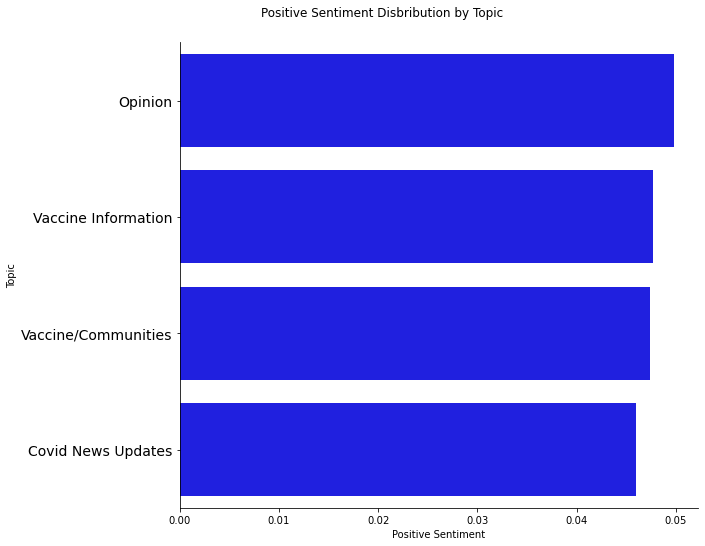

In [30]:
plot=sns.catplot(y='topic',
                 x='pos_p', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['pos_p'],ascending=False), 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Positive Sentiment Disbribution by Topic', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-85.075, 0.5, 'Topic')

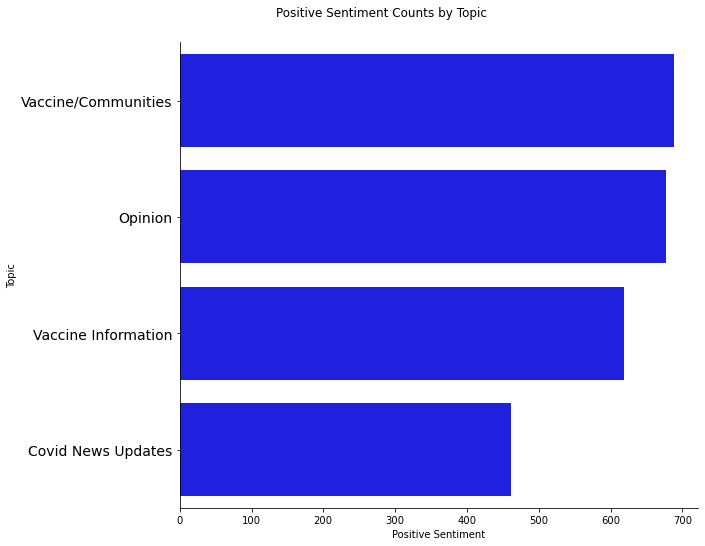

In [31]:
plot=sns.catplot(y='topic',
                 x='pos', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['pos'],ascending=False), 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Positive Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

In [32]:
sent_df=full_data[full_data.columns[-13:]]

In [33]:
sent_df.head(2)

,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,neg_sent,neu_sent,pos_sent,compound_sent,tb_score,tb_subj,tb_sent,tb_sent_subj,v_sent
0,0.114,0.676,0.210,0.6124,0.114,0.676,0.210,0.6124,0.233333,0.766667,pos,pos,pos
1,0.000,0.837,0.163,0.7041,0.000,0.837,0.163,0.7041,0.000000,0.500000,pos,neu,pos


In [34]:
sent_df[(sent_df.tb_subj>.6)&(sent_df.tb_sent_subj=='pos')].sort_values(by='compound_sent',ascending=False)

,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,neg_sent,neu_sent,pos_sent,compound_sent,tb_score,tb_subj,tb_sent,tb_sent_subj,v_sent
40767,0.023,0.529,0.447,0.9804,0.023,0.529,0.447,0.9804,0.294444,0.647685,pos,pos,pos
42921,0.039,0.516,0.445,0.9755,0.039,0.516,0.445,0.9755,0.783333,0.883333,pos,pos,pos
17818,0.045,0.601,0.354,0.9751,0.045,0.601,0.354,0.9751,0.478125,0.658333,pos,pos,pos
27926,0.039,0.626,0.336,0.9684,0.039,0.626,0.336,0.9684,0.414286,0.680952,pos,pos,pos
1222,0.028,0.598,0.374,0.9650,0.028,0.598,0.374,0.9650,0.305000,0.720000,pos,pos,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12564,0.076,0.791,0.132,0.5042,0.076,0.791,0.132,0.5042,-0.075000,0.750000,pos,pos,pos
30325,0.109,0.668,0.223,0.5023,0.109,0.668,0.223,0.5023,-0.192857,0.735714,pos,pos,pos
22947,0.127,0.650,0.223,0.5023,0.127,0.650,0.223,0.5023,0.000000,1.000000,pos,pos,pos
31886,0.029,0.856,0.115,0.5020,0.029,0.856,0.115,0.5020,0.400000,0.633333,pos,pos,pos


Notes: There will require a lot more time digging into classifying what is 'positive' and what is 'negative'. I believe the subjectivity feature will be highly valuable in learning what regular folks feel.<br><br> 
Take a look below. I have printed 'positive' tweets, that are highly subjective. Though the majority are negative and sarcastic.

### Positive

In [35]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_sent_subj=='pos')].sort_values(by='compound_sent',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

@ashlieatkinson Yes your that worried about your health you don’t mind wearing a mask but you don’t care about stuffing your face. Good luck getting an experimental vaccine. Good luck sweetheart. #NoVaccine 
----

Medicine has this bias where you can't do anything unless you're super super super super sure it's not bad. A pandemic requires bolder decision making. It's pretty clear to me, a layperson, that we should get first doses into as many people as possible first. https://t.co/yco6v7urwz 
----

@PFr1end @Nicole86201389 @endtimeslife As a Christian taking the vax is like having experimental plastic surgery done but in reverse. God's protect me from the virus by giving me an amazing immune system that can deal perfectly w/it. I will not be vaccinated! May my Lord Yeshua judge. In Him alone I trust. Luke 12:7🛐 https://t.co/KmoWW6idyW 
----

@joqween @ColorsOfTheWi13 DEAR TEXANS: Because you —
are tough
are fighters
love freedom
love life
PLEASE CONTINUE TO —
wear your mask
wash your 

[None, None, None, None, None]

The following are tweets with a slightly different filter. It's highly subject and highly positive according to textblob.<br><br>

It's interesting that these speak to education of vaccines or the progress of tackling the pandemic

In [36]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score>.5)].sort_values(by='tb_score',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Great, @barnes_weise &amp; @GHIAAteam! The nitty-gritty of #COVID19 vaccines. #VaccinesWork #VaccinEquity https://t.co/CmFHhfkjKK 
----

It's numbers like this that make me think we are onto something #vaccination #covid #hope Really impressed at how well this has been organised and how well people are responding https://t.co/auMVLi1ZW3 
----

@RepAndyBiggsAZ Lol he didn’t even take the vaccine. It’s the Trump Virus! 
----

Check out this awesome @aafp @familydoctor video! #ThisIsOurShot @ThisIsOurShot #VaccinesWork https://t.co/LnZWhJDCZ0? 
----

One word to describe how the Mamata Banerjee government is handling the #COVID19 #vaccine roll out: Impressive. @Mamataofficial 

Here 👇 https://t.co/IrwqpFb1kG 
----



[None, None, None, None, None]

The following are tweets were tweaked a bit further. It's highly subject and highly positive according to vader sentiment. It's the same as above, only ranked by vader sentiment compound score, cutoffs were the same.<br><br>

There is a possibility that some of these are not referring to the pandemic, but were picked up originally for words like 'virus', not in the context of the covid-19 pandemic.<br><br>
With that said - it's interesting that these focus on fun activities & family time/experiences despite or due to the pandemic.

In [37]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score>.5)].sort_values(by='compound_sent',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Congrats to @ericbouck and @Robsaysthings for the launch of @HedgehogTrivia! I've been on many games -- great hosts, great questions, super fun and entertaining. Great way to facilitate team bonding!! https://t.co/pnGqseJo4X #WFH #COVID19 #teamfun 
----

@SunlitS_J  you’ve had some lovely videos from some lovely people today, I bet Jack is really happy that Captain Seb was there for him this morning. I’m proud of you both for bringing everyone together in this pandemic, &amp; for being a great friend. Thank you. 🤗🤗 for Jack. 
----

Happiest Birthday to our dork yet cool brave man! Thank you for being our happy virus. Thank you for sharing your talent to all of us. May you continue to shine like a star! Yejiapsa, mochi!💙 
Your Omega, J.
@OFFICIALBTOB @LeeCS_BTOB
#BORN_TO_BE_CHANGSUB 
https://t.co/CSeCqsg8ra 
----

🍊Defense Boost Vitamin C Gummies are crafted with a delicious flavor and vital nutrients and antioxidants to help encourage optimal wellness and support your immune system.

#

[None, None, None, None, None]

### Negative

Same as above, but fliped for negative sentiments

Side note - I've seen 'asian american' terms come up. It would be interesting to see how that term trends over time due to the pandemic

A pretty good mix of the most negative tweets. It seems to be negative sentiment around politics, the disruption of the pandemic, racism, anti-vaxers. It seems to be more of the same topics in the news today.

An interesting find though ... some of the 'positive' sentiments above could gain more insight into what folks 'feel' or think about a vaccine. For example, if a person who is not into taking vaccine, would not talk negativley about not taking the vaccine. They would say how their decision is good, and explain why. It may be worth it to do more EDA into neg vs positive to find these nuances.

In [38]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_sent_subj=='neg')].sort_values(by='compound_sent',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Marxism.... Max stress 
Fake news
Fake pandemic
Fake elections.
Fake president
Fake white supremacy
Fake extremism
Fake Trump insurrection
Fake Kamala not afr amer
Fake climate change
Fake Biden Healing 
Fake Vax https://t.co/48Y2W7FDr7 
----

@GOP Trump’s d worst POTUS &amp; most incompetent ever! Shameless &amp; biggest loser incumbent ever! A pathological liar, racist &amp; unstable! Narcissist, traitor, Insurrectionist, dishonorable, d most corrupt &amp; amoral! He’s vaccinated secretly while lying to his stupid supporters about covid 
----

The vax seeks to reduce costs of Covid, but how much weight to give to hospitalizations and death, how much to economic disruptions, how much to devastating harm faced by our children? I never imagined that the that % chance of death by age would be the only thing that matters. 
----

I hate these anti-vaxers like bitch you really just wanna die even though you’ve been vaxed your whole life? Idk stop changing shit also why now? You sound stupid

[None, None, None, None, None]

In [39]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score<.5)].sort_values(by='tb_score',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

RT @KurlyKrissy: "Pfizer is holding govts to ransom!"

Quite a shocking report!

Imagine for a minute that to push through a vaccine there… 
----

#VaccinesWork #VaccinesSaveLives @morgfair won’t be hospitalized or very ill from COVID-19!!!!!!! https://t.co/wzjLBtrNl0 
----

Arizona has suffered from one of the worst coronavirus outbreaks in the country. We need additional vaccine doses to save lives and provide immediate help to Arizona seniors, people with pre-existing conditions, frontline workers, and tribal communities. https://t.co/vZLEgq0kgb 
----

@bbcquestiontime What people will do for a bloody holiday!
Ignoring a lifetime of irreversible risk!
#VaccinePassports #bbcqt #covid #vaccine 
👇👇👇 https://t.co/a2sihhYsYU 
----

@BlairKing_ca @Justin_Ling 32M people vaccinated &lt;18 mths after the worst pandemic in over 100 years, and you're pissing and moaning. You know those people your parents warned you about, that no matter what, all they want to do is complain? Yeah, it's you. 

[None, None, None, None, None]

This below filter is similar to the first one

In [40]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score<.5)].sort_values(by='compound_sent',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Marxism.... Max stress 
Fake news
Fake pandemic
Fake elections.
Fake president
Fake white supremacy
Fake extremism
Fake Trump insurrection
Fake Kamala not afr amer
Fake climate change
Fake Biden Healing 
Fake Vax https://t.co/48Y2W7FDr7 
----

@CSandbox @DrDooleyMD I hate 2 say it but hypothesis of various doctors / evidence oFMANDATORY FLU VAX stats from MILITARY show u got flu shot &amp; u hv higher % get sick w covid19 disease not SARS COV2! Italians had highest population OLD FOLKS ESP of lethal FLU VAX &amp; worst covid19 disaster! All connecT 
----

@GOP Trump’s d worst POTUS &amp; most incompetent ever! Shameless &amp; biggest loser incumbent ever! A pathological liar, racist &amp; unstable! Narcissist, traitor, Insurrectionist, dishonorable, d most corrupt &amp; amoral! He’s vaccinated secretly while lying to his stupid supporters about covid 
----

@BekahTheBold @Lui_101499 @WSJ No. I'm saying y would a 58 yr old just drop dead "coincidentally" after a Covid vax. She's not the

[None, None, None, None, None]

In [41]:
sent_byuser_dict = defaultdict(list)

sent_vals = {'neu','pos','neg'}

for x, user in tqdm(enumerate(full_data.user_id.unique())):
    cnts = full_data[full_data.user_id==user].tb_sent_subj.value_counts(normalize=True)
    
    for idx in cnts.index:
        sent_byuser_dict[idx+'_p'].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_byuser_dict[s+'_p'].append(0)
    
    
    cnts = full_data[full_data.user_id==user].tb_sent_subj.value_counts()
    
    for idx in cnts.index:
        sent_byuser_dict[idx].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_byuser_dict[s].append(0)
    
    sent_byuser_dict['user'].append(user)

<ipython-input-41-15e240dd1237>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, user in tqdm(enumerate(full_data.user_id.unique())):


0it [00:00, ?it/s]

In [42]:
sent_cnts_users = pd.DataFrame.from_dict(sent_byuser_dict)
sent_cnts_users['user']=sent_cnts_users.user.apply(lambda x: str(int(x)))
display(sent_cnts_users.head(2))

,pos_p,neu_p,neg_p,pos,neu,neg,user
0,1.0,0.0,0.0,1,0,0,29501253
1,0.0,1.0,0.0,0,3,0,1201670995435646976


Text(-98.325, 0.5, 'Users')

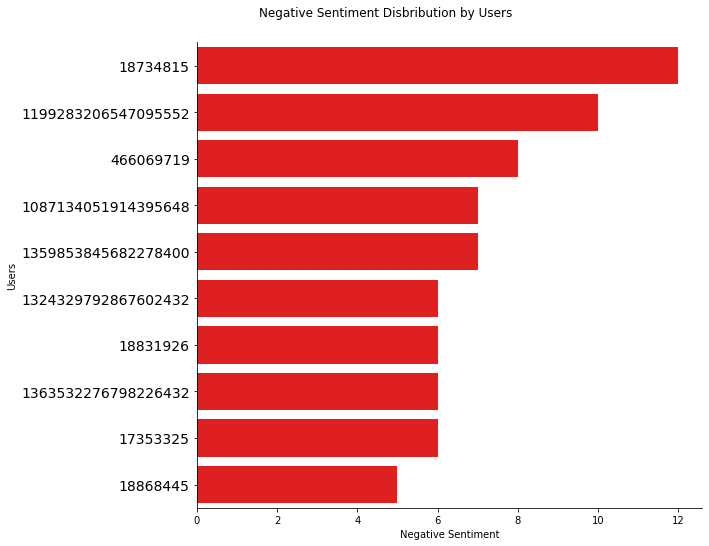

In [43]:
plot=sns.catplot(y='user',
                 x='neg', 
                 kind='bar',
                 data = sent_cnts_users.sort_values(by=['neg'],ascending=False)[:10], 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Disbribution by Users', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Users')
# fig.show()

18734815 => removed <br>
1199283206547095552 => removed <br>
466069719 => removed <br>
1087134051914395648 => removed<br>
1359853845682278400 => Error: Not Found*<br>
1324329792867602432 => Error: Not Found*<br>
18831926 => removed<br>
1363532276798226432 => Error: Not Found*<br>
17353325 => removed<br>
18868445 => removed<br>
<br><br><br>
These user ids did not return a value. It could be that this user deleted their account, or, during wrangling python has rounded the user id variable while it was a number, making the number different

#### 5 of the negative tweets from @24AheadDotCom

In [44]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==18734815][:5].full_text) if full_data[(full_data.user_id==18734815)].iloc[i].tb_sent_subj=='neg']

@AaliaAnthony @HildaSolis @Cleavon_MD @LACDevAuthority @Curative @lapublichealth 95% of C19 deaths were 50+ &amp; risk factors play a major role. Vax them &amp; there's basically no more pandemic.

Instead, @HildaSolis wants to vax young/healthy people of the "right race" before seniors/high risk of the "wrong race" because she's David Duke with a tan.
@m2angels2 @luna_c_is_here @GavinNewsom The solution is simple: vax by ICU risk. Cover seniors/high risk - those most likely to die - and the spread doesn't matter.

@GavinNewsom is going about it backwards: vaxing young/healthy before seniors/high risk. That increases deaths &amp; prolongs the pandemic.
@TexasDoctorCool @SenToniAtkins @GavinNewsom The problem is with con leaders. Newsom is extremely vulnerable on his vax tiers that are prolonging the pandemic &amp; increasing deaths.

Instead of harping on that, con leaders act like their kids &amp; whine about school sports as Newsom is literally killing people.


[None, None, None]

#### 5 of the negative tweets from @stefan90671458

In [45]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==1199283206547095552][:5].full_text) if full_data[(full_data.user_id==18734815)].iloc[i].tb_sent_subj=='neg']

The world round us wil be made to coerce us into taking Phizers DNA🧬Rna vax. Public transport,favorite events,restaurants,workplaces,travel etc &amp; for what a virus that has 99.997% recovery rate 900 dead/26,000,000, u have more of chance of dying in car accident 1500 dead 2019🇦🇺
@newscomauHQ The world round us wil be made to coerce us into taking Phizers DNA🧬Rna vax. Public transport,favorite events,restaurants,workplaces,travel etc &amp; for what a virus that has 99.997% recovery rate 900 dead/26,000,000, u have more of chance of dying in car accident 1500 dead 2019🇦🇺
@theheraldsun The world round us wil be made to coerce us into taking Phizers DNA🧬Rna vax. Public transport,favorite events,restaurants,workplaces,travel etc &amp; for what a virus that has 99.997% recovery rate 900 dead/26,000,000, u have more of chance of dying in car accident 1500 dead 2019🇦🇺


[None, None, None]

Text(-98.325, 0.5, 'Users')

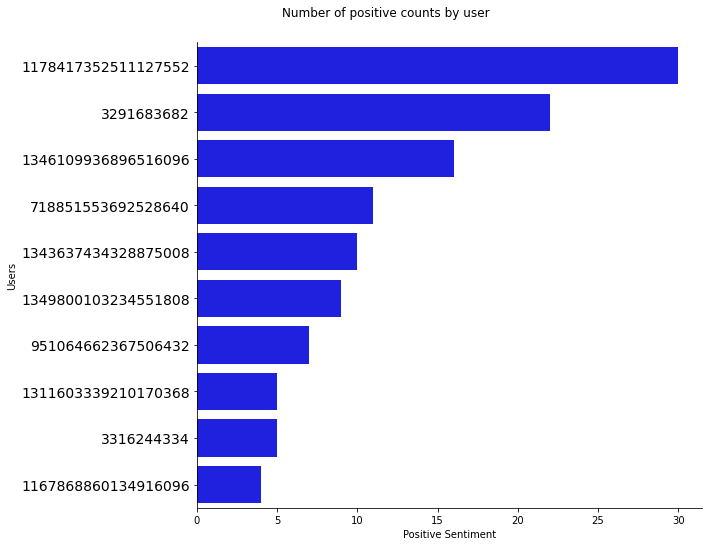

In [46]:
plot=sns.catplot(y='user',
                 x='pos', 
                 kind='bar',
                 data = sent_cnts_users.sort_values(by=['pos'],ascending=False)[:10], 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Number of positive counts by user', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Users')
# fig.show()

In [47]:
[print(str(int(i))) for i in sent_cnts_users.sort_values(by=['pos'],ascending=False)[:10].user]

1178417352511127552
3291683682
1346109936896516096
718851553692528640
1343637434328875008
1349800103234551808
951064662367506432
1311603339210170368
3316244334
1167868860134916096


[None, None, None, None, None, None, None, None, None, None]

In [48]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==1178417352511127552][:5].full_text) if full_data[(full_data.user_id==1178417352511127552)].iloc[i].tb_sent_subj=='pos']

@CPAC Our entire country has been screwed thanks to #Trump 
#TrumpKnewAndDidNothing 
He denied the virus &amp; the science, he put our country far behind &amp; held super spreader events. The USA makes up 4% of the world's population but 25% of #COVID19 cases/deaths 😪 in the richest country!
@laurenboebert @CPAC Our entire country has been screwed thanks to #Trump 
#TrumpKnewAndDidNothing 
He denied the virus &amp; the science, he put our country far behind &amp; held super spreader events. The USA makes up 4% of the world's population but 25% of #COVID19 cases/deaths 😪 in the richest country!
@GOD_N_GUN @CPAC @MAJTOURE Our entire country has been screwed thanks to #Trump 
#TrumpKnewAndDidNothing 
He denied the virus &amp; the science, he put our country far behind &amp; held super spreader events. The USA makes up 4% of the world's population but 25% of #COVID19 cases/deaths 😪 in the richest country!
@LarryOConnor @CPAC @bboinc14 @odonnell_r @KABCRadio @WMALDC Our entire country has b

[None, None, None, None, None]

The above person with the most positive tweets shows a couple things.
The suppports that more work is needed to define 'positive' and 'negative'. The above tweets I would characterize as negative / sarcastic. <br>
Also - It looks like either this person retweeted or tweeted the same post multiple times to show his passion on the subject, or, there are multiple tweets in the dataset

In [49]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==3291683682][:5].full_text) if full_data[(full_data.user_id==3291683682)].iloc[i].tb_sent_subj=='pos']

@deNutrients Significant clinical  benefits 
https://t.co/o3GI3to7CG
https://t.co/7Bj66Lz2H4 
https://t.co/hDAFUf2d47 
Over-the-Counter prevention &amp; therapy
https://t.co/qchnVb7SqH
Vitamin D &amp; Quercetin inhibit viral entry &amp; Vitamin D+ QCT + Estradiol interfere with 26/27 (96%) virus proteins
Significant clinical  benefits 
https://t.co/o3GI3to7CG
https://t.co/7Bj66Lz2H4 
https://t.co/hDAFUf2d47 
Over-the-Counter prevention &amp; therapy
https://t.co/qchnVb7SqH
Vitamin D &amp; Quercetin inhibit viral entry &amp; Vitamin D+ QCT + Estradiol interfere with 26/27 (96%) virus proteins https://t.co/EhHEURxbIz
@wbgrant2 Significant clinical  benefits 
https://t.co/o3GI3to7CG
https://t.co/7Bj66Lz2H4 
https://t.co/hDAFUf2d47 
Over-the-Counter prevention &amp; therapy
https://t.co/qchnVb7SqH
Vitamin D &amp; Quercetin inhibit viral entry &amp; Vitamin D+ QCT + Estradiol interfere with 26/27 (96%) virus proteins
@QuantumHealthTV @Jonathan_K_Cook Significant clinical  benefits 
https://

[None, None, None, None, None]

verify that the above are different tweets, different tweet ids

In [50]:
print('count of this was posted at different times: ',full_data[(full_data.user_id==3291683682)&(full_data.tb_sent_subj=='pos')].created_at.nunique())
print('number of different tweet ids: ',full_data[(full_data.user_id==3291683682)&(full_data.tb_sent_subj=='pos')].tweet_id.nunique())

count of this was posted at different times:  22
number of different tweet ids:  22
